# Intrinsic Time Framworks
- An event-based definition of time.
- Only interactions, or events, let the clock tick.

## Directional Change
This framework operates on a threshold of price change, either upwards or downwards. A 'tick' or new time step is recorded when the price moves a predetermined percentage or absolute value from the last extremum (highest or lowest point).

<br>

**Example:**<br>
A trader might set a 2% threshold for a stock. Each time the stock price reverses by at least 2% from the last peak or trough, a new intrinsic time point is recorded, which can be used to analyze the frequency and magnitude of reversals.

## Data preparation

In [40]:
import pandas as pd

csv_file_path = '/Users/JasminePai/Downloads/HISTDATA_COM_ASCII_EURGBP_T201606/DAT_ASCII_EURGBP_T_201606.csv'  # Change to your CSV file path
data = pd.read_csv(csv_file_path, header=None)
data.columns = ['Timestamp', 'Bid', 'Ask', 'Volume']

# Convert the timestamps to a datetime format for easier manipulation
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y%m%d %H%M%S%f')


In [1]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for the FX pair (e.g., "EURUSD=X" for EUR/USD)
fx_ticker = "EURUSD=X"

# Fetch data
fx_data = yf.download(fx_ticker, period="3mo", interval="1h")

# Extract the daily closing prices
closing_prices = fx_data['Close']


[*********************100%***********************]  1 of 1 completed


In [2]:
closing_prices

2024-02-16 11:00:00+00:00    1.078167
2024-02-16 12:00:00+00:00    1.077122
2024-02-16 13:00:00+00:00    1.075038
2024-02-16 14:00:00+00:00    1.075616
2024-02-16 15:00:00+00:00    1.077354
                               ...   
2024-05-16 08:00:00+01:00    1.087784
2024-05-16 09:00:00+01:00    1.087666
2024-05-16 10:00:00+01:00    1.087311
2024-05-16 11:00:00+01:00    1.087429
2024-05-16 11:13:08+01:00    1.087548
Name: Close, Length: 1523, dtype: float64

In [3]:
tick_data = pd.DataFrame()

In [4]:
tick_data['CurrentPrice'] = closing_prices
tick_data.index = pd.to_datetime(tick_data.index)
tick_data['Timestamp'] = tick_data.index.strftime('%Y%m%d %H%M%S%f')
tick_data = tick_data.reset_index(drop=True)

In [5]:
tick_data

,CurrentPrice,Timestamp
0,1.078167,20240216 110000000000
1,1.077122,20240216 120000000000
2,1.075038,20240216 130000000000
3,1.075616,20240216 140000000000
4,1.077354,20240216 150000000000
...,...,...
1518,1.087784,20240516 080000000000
1519,1.087666,20240516 090000000000
1520,1.087311,20240516 100000000000
1521,1.087429,20240516 110000000000


In [57]:
tick_data['CurrentPrice'] = (tick_data['Bid'] + tick_data['Ask'])/2

tick_data

KeyError: 'Bid'

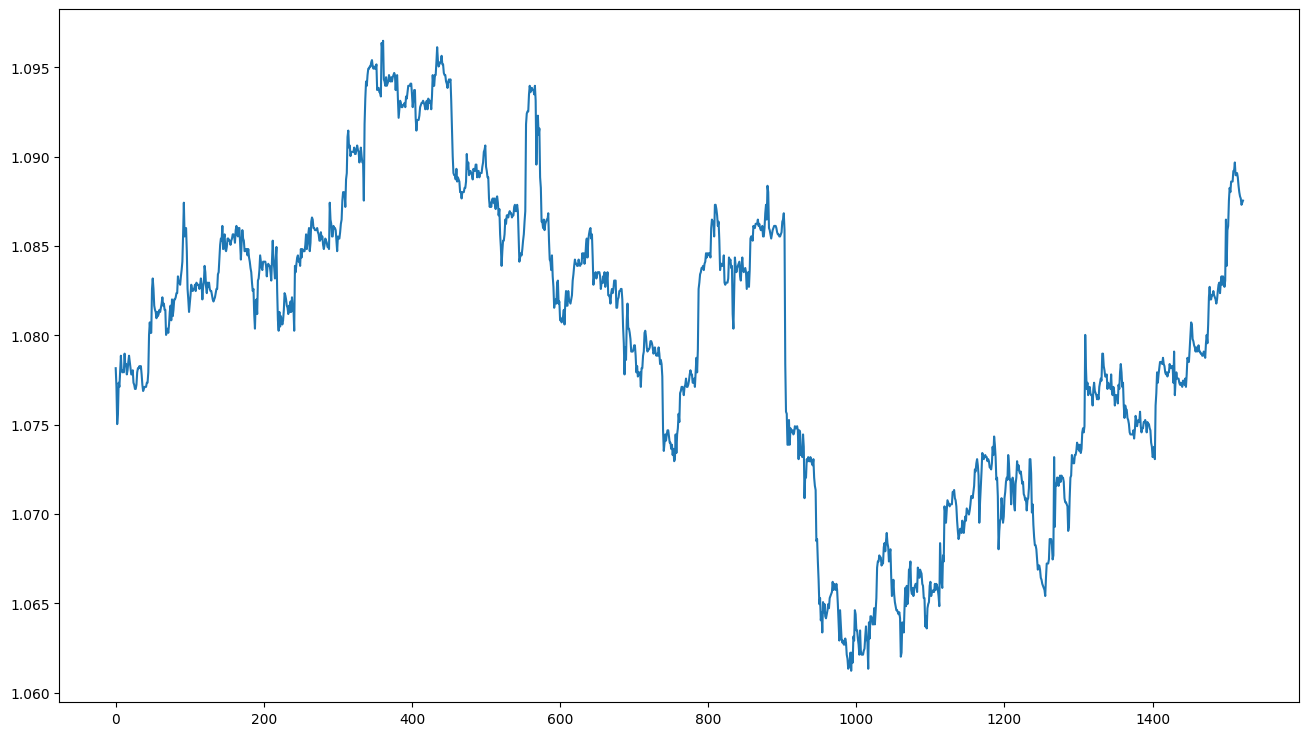

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.plot(tick_data['CurrentPrice'])

## Intrinsic time ( physical time to directional change time)
<br>

**pseudocode (Process Tick for Directional Change)**

---
```python
Define function process_tick_DC with parameters tick, ext, mode, threshold

    If mode is 'down':
        If tick is less than ext:
            Update ext to tick
            Return 0, mode, ext, 0

        Else if the percentage change from ext to tick is greater than or equal to threshold:
            Update mode to 'up'
            Set OS to ext
            Update ext to tick
            Return 1, mode, ext, OS

        Else:
            Return 0, mode, ext, 0

    Else (if mode is not 'down'):
        If tick is greater than ext:
            Update ext to tick
            Return 0, mode, ext, 0

        Else if the percentage change from ext to tick is greater than or equal to threshold:
            Update mode to 'down'
            Set OS to ext
            Update ext to tick
            Return -1, mode, ext, OS 
        Else:
            Return 0, mode, ext, 0

End of function
```
---

In [7]:
def process_tick_DC(tick, ext, mode, delta):
    if mode == 'down':
        if tick < ext:
            ext = tick
            return 0, mode, ext, 0 # no event, price keep going down
        elif (tick - ext)/ext >= delta:
            mode = 'up'
            OS = ext
            ext = tick
            return 1, mode, ext, OS # Directional change upwards confirmed, and overshoot end point is defined
        else:
            return 0, mode, ext, 0 # no event, price go up but the change does not greater than delta
    else:
        if tick > ext:
            ext = tick
            return 0, mode, ext, 0 # no event, price keep going up
        elif (ext - tick)/ext >= delta:
            mode = 'down'
            OS = ext
            ext = tick
            return -1, mode, ext, OS # Directional change downward confirmed, and overshoot end point is defined
        else:
            return 0, mode, ext, 0 # no event, price go down but the change does not greater than delta

In [8]:
ticks = tick_data['CurrentPrice']  # list of tick prices

delta_range = [0.001,0.002, 0.003, 0.004, 0.005]  # Set theta value (define the significance of price change percentage)

for delta in delta_range:
    i = 0 # help to record the index for overshoot start point
    events = []
    overshoots = []
    mode = 'up' if ticks[1] > ticks[0] else 'down'
    ext = ticks[0]
    OS = ticks[0]
    for tick in ticks:
        event, mode, ext, OS = process_tick_DC(tick, ext, mode, delta)
        events.append(event) # directional change
        
        if OS == 0:
            overshoots.append(0)
        else:
            temp_df = ticks[:i+1] 
            last_os = temp_df[temp_df == OS ].last_valid_index() # the OS value is the lastest extreme point, which becomes overshoot start point. 

            if event == 1:
                overshoots.append(-last_os) # once the directional change (upward) confirmed, previous overshoot (down) end point confirmed. This save the index of the previous overshoot point.
            else:
                overshoots.append(last_os) # once the directional change (downward) confirmed, previous overshoot (up) end point confirmed. This save the index of the previous overshoot point.
                         
        i = i+1
        
    tick_data[f'Event (delta={delta*100}%)'] = events
    tick_data[f'Overshoot (delta={delta*100}%)'] = overshoots

In [9]:
tick_data

,CurrentPrice,Timestamp,Event (delta=0.1%),Overshoot (delta=0.1%),Event (delta=0.2%),Overshoot (delta=0.2%),Event (delta=0.3%),Overshoot (delta=0.3%),Event (delta=0.4%),Overshoot (delta=0.4%),Event (delta=0.5%),Overshoot (delta=0.5%)
0,1.078167,20240216 110000000000,0,0,0,0,0,0,0,0,0,0
1,1.077122,20240216 120000000000,0,0,0,0,0,0,0,0,0,0
2,1.075038,20240216 130000000000,0,0,0,0,0,0,0,0,0,0
3,1.075616,20240216 140000000000,0,0,0,0,0,0,0,0,0,0
4,1.077354,20240216 150000000000,1,-2,1,-2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1.087784,20240516 080000000000,0,0,0,0,0,0,0,0,0,0
1519,1.087666,20240516 090000000000,0,0,0,0,0,0,0,0,0,0
1520,1.087311,20240516 100000000000,0,0,-1,1511,0,0,0,0,0,0
1521,1.087429,20240516 110000000000,0,0,0,0,0,0,0,0,0,0


In [10]:
# flag the overshoots based on the previous saving index
# integrate directional change confirmed point and overshoots in a column

for delta in delta_range:
    Overshoots = tick_data[~tick_data[f'Overshoot (delta={delta*100}%)'].isin([0])][f'Overshoot (delta={delta*100}%)']
    for os in Overshoots:
        if tick_data[f'Event (delta={delta*100}%)'][abs(os)] == 0 :
            if os > 0:
                tick_data[f'Event (delta={delta*100}%)'][os] = 2
            else:
                tick_data[f'Event (delta={delta*100}%)'][-os] = -2

/var/folders/pb/n3jzr__s3r73df3nb74tq_y00000gn/T/ipykernel_1156/1309098884.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_data[f'Event (delta={delta*100}%)'][-os] = -2
/var/folders/pb/n3jzr__s3r73df3nb74tq_y00000gn/T/ipykernel_1156/1309098884.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tick_data[f'Event (delta={delta*100}%)'][os] = 2


Testing whether the smaller thresholds produce more events than larger ones.
<br>
The following table clearly shows that as the threshold(delta) increases, the number of times of directional change decreases.

In [11]:
df_DC_events = pd.DataFrame()
df_DC_events.index = ['Directional Changes','Overshoots']

for delta in delta_range:
    df_DC_events.loc['Directional Changes',f'delta={delta*100}%'] = len(tick_data[(tick_data[f'Event (delta={delta*100}%)'] == 1) | (tick_data[f'Event (delta={delta*100}%)'] == -1)])
    df_DC_events.loc['Overshoots',f'delta={delta*100}%'] = len(tick_data[(tick_data[f'Event (delta={delta*100}%)'] == 2) | (tick_data[f'Event (delta={delta*100}%)'] == -2)])    

df_DC_events

,delta=0.1%,delta=0.2%,delta=0.3%,delta=0.4%,delta=0.5%
Directional Changes,146.0,74.0,39.0,27.0,17.0
Overshoots,109.0,61.0,33.0,22.0,16.0


In [12]:
# remove the columns which are not needed anymore.

remove_col = [f'Overshoot (delta={delta*100}%)' for delta in delta_range]
tick_data = tick_data.drop(columns=remove_col)
tick_data

,CurrentPrice,Timestamp,Event (delta=0.1%),Event (delta=0.2%),Event (delta=0.3%),Event (delta=0.4%),Event (delta=0.5%)
0,1.078167,20240216 110000000000,0,0,0,0,0
1,1.077122,20240216 120000000000,0,0,0,0,0
2,1.075038,20240216 130000000000,-2,-2,-2,-2,-2
3,1.075616,20240216 140000000000,0,0,0,0,0
4,1.077354,20240216 150000000000,1,1,0,0,0
...,...,...,...,...,...,...,...
1518,1.087784,20240516 080000000000,0,0,0,0,0
1519,1.087666,20240516 090000000000,0,0,0,0,0
1520,1.087311,20240516 100000000000,0,-1,0,0,0
1521,1.087429,20240516 110000000000,0,0,0,0,0


Plotting the price trend based on different thresholds.

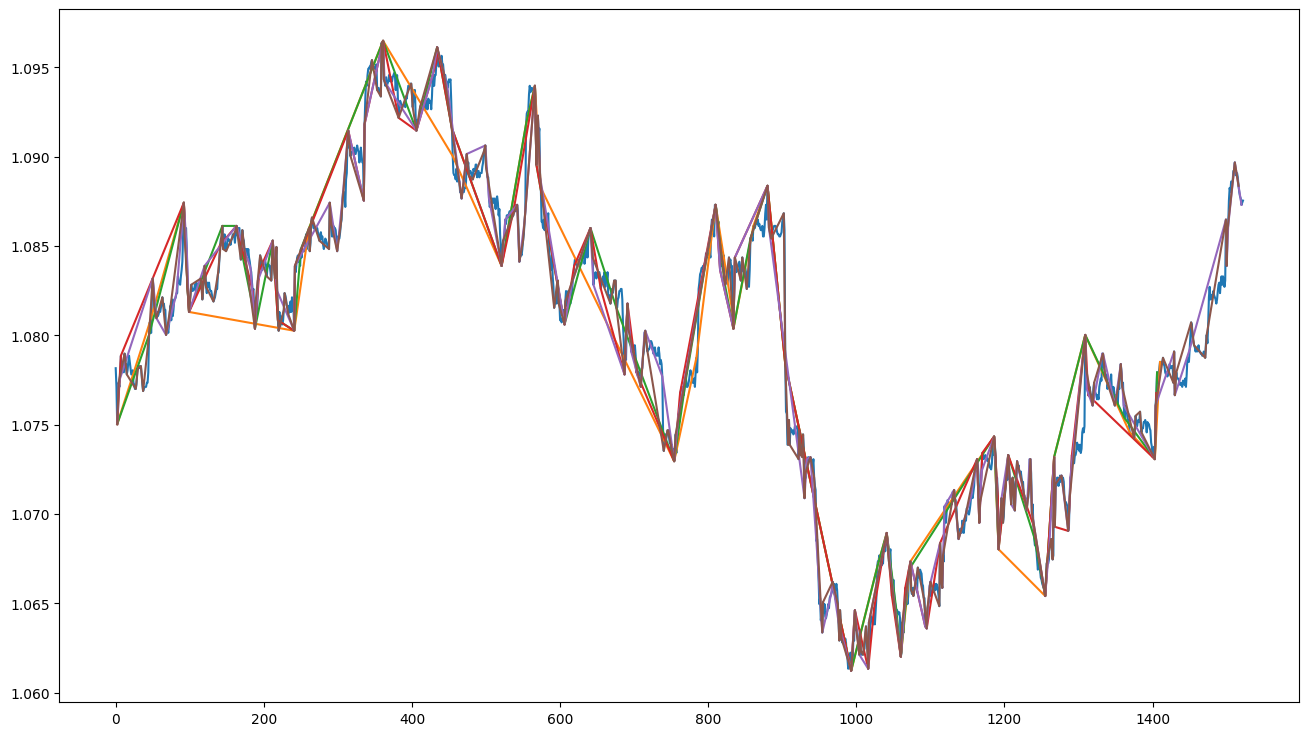

In [13]:
plt.figure(figsize=(16, 9))
plt.plot(tick_data['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-1].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-2].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-3].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-4].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-5].isin([0])]['CurrentPrice'])

By zooming in on the plot, we can clearly observe the trends under different thresholds.

(1.075, 1.095)

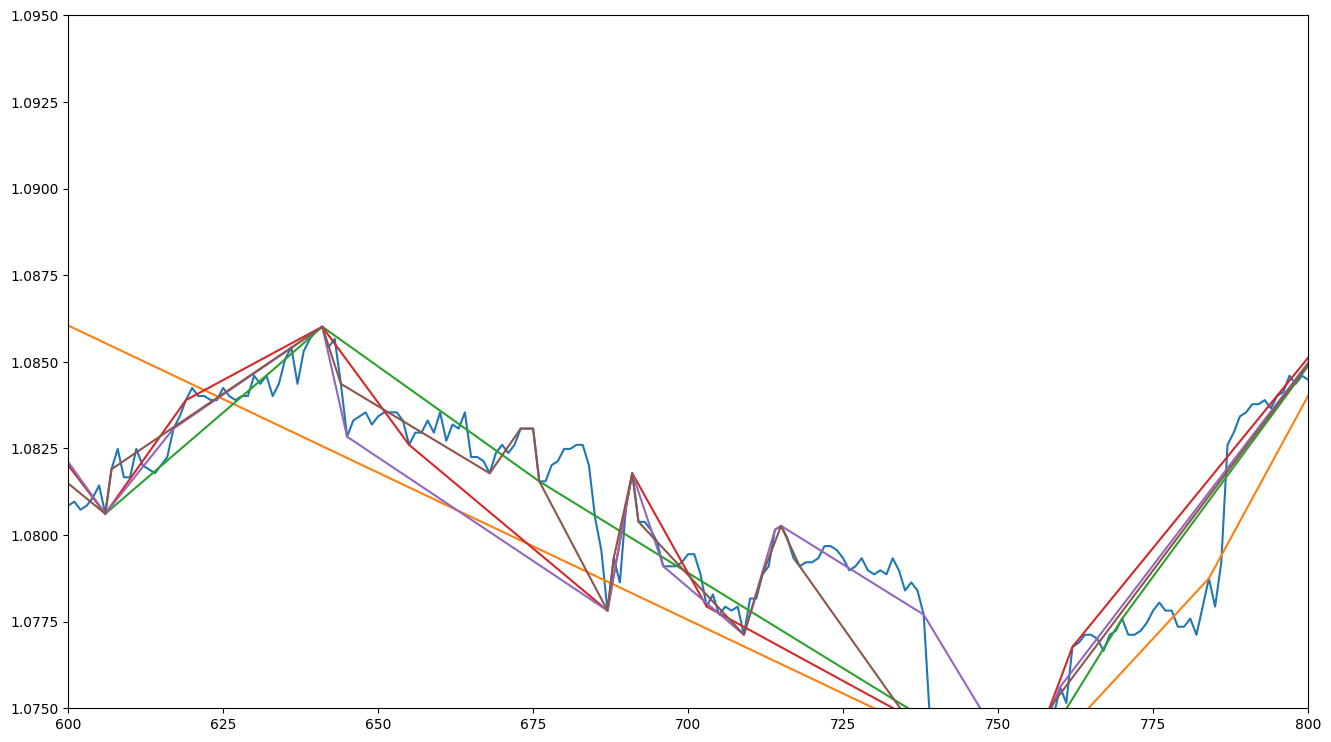

In [14]:
plt.figure(figsize=(16, 9))
plt.plot(tick_data['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-1].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-2].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-3].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-4].isin([0])]['CurrentPrice'])
plt.plot(tick_data[~tick_data.iloc[:,-5].isin([0])]['CurrentPrice'])
plt.xlim(600, 800)
plt.ylim(1.075,1.095)

According to the results of statistical properties, the average overshoot should be approximately the same as the threshold.

In [15]:
import statistics

for delta in delta_range:
    df_temp = tick_data[~tick_data.loc[:,f'Event (delta={delta*100}%)'].isin([0])]
    l_os_check = []
    for i in range(1,len(df_temp)):
        if df_temp[f'Event (delta={delta*100}%)'].iloc[i] == 2:
            os_value = df_temp['CurrentPrice'].iloc[i]-df_temp['CurrentPrice'].iloc[i-1]
            l_os_check.append(os_value)
    
    print(f'Threshold= {delta*100}% ({delta})')
    print(f'Average Overshoot= {statistics.mean(l_os_check)}\n')
 

Threshold= 0.1% (0.001)
Average Overshoot= 0.0024543912322432908

Threshold= 0.2% (0.002)
Average Overshoot= 0.0031120415889855585

Threshold= 0.3% (0.003)
Average Overshoot= 0.0042082518339157104

Threshold= 0.4% (0.004)
Average Overshoot= 0.005105507373809814

Threshold= 0.5% (0.005)
Average Overshoot= 0.005738541483879089



The result shows this dataset does follow this statistical property, which can be utilised in creating trading strategies.
<br><br>
By this result, we can find that the average overshoot is usually slightly higher than the threshold, which may affect the strategies design when considering the timing to take profit and stop loss.

## Trading strategies
The following strategies are extensions of the strategy discussed in the lab section.
<br><br>
### <font color = navy>1. Directional Change Long position (lab)<font>
- open a long position at the directional change confirmed
- taking the profit when the current price is half of the threshold higher than the open price.
- stopping the loss, which means closing the position, when the current price is half of the threshold lower than the open price.

**pseudocode (Directional Change Long position (lab))**

---
```Python
Function DC_Long_S1 takes data and a threshold as inputs

    Initialize long_position to False
    Initialize entry_price to 0
    Initialize take_profit to 0
    Initialize stop_loss to 0
    Initialize performance as an empty list
    Filter the data for events where the directional change equals 1

    For each index, row in the data
        Get the current_price from the row

        If not in a long_position and the event indicates opening a long position
            Set long_position to True
            Set entry_price to current_price
            Calculate take_profit as entry_price times (1 + threshold/2)
            Calculate stop_loss as entry_price times (1 - threshold/2)

        If in a long_position
            If current_price is greater or equal to take_profit 
               or current_price is less or equal to stop_loss
                Calculate the trade result and append to performance
                Set long_position to False

    Return the performance list


End Function
```
---

In [16]:
def DC_Long_S1(data, threshold):
    # Initialize variables
    long_position = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    performance = []
    data = data[~data.loc[:,f'Event (delta={threshold*100}%)'].isin([0])]
    
    for index, row in data.iterrows():
        current_price = row['CurrentPrice']
        if not long_position and row[f'Event (delta={threshold*100}%)']==1: # open Long position when Directional change upwards confirmed
            long_position = True
            entry_price = current_price
            take_profit = entry_price * (1 + threshold/2)
            stop_loss = entry_price * (1 - threshold/2)
        
        if long_position:
            if current_price >= take_profit or current_price <= stop_loss:
                performance.append(current_price - entry_price)
                long_position = False
    
    return performance

However, there are several limits to this strategy, including only accepting having one position at the same time and only opening a long position. These lead to potential losses when the price has a downward trend. Also, the timing for stopping loss and taking profit should be adjustable to confirm the best setting for them.

### <font color = navy>2. Directional Change Long position<font>
<br>
This strategy focuses on the relationship between the total performance and the timing of taking profit and stopping loss based on the threshold.

    
- open a long position at the directional change upward confirmed
- taking the profit when the current price is higher than the open price by a given value. In other words, if the given value is TP = 0.75, then the target price of taking profit will be open price * (1+threshold * 0.75).
- stop the loss when the current price is lower than the open price by a given value. In other words, if the given value is SL = 0.25, then the target price of stopping loss will be open price * (1-threshold * 0.25).

**pseudocode (Directional Change Long position)**

---
```python
Function DC_Long_S2 takes data, a threshold, take profit (TP), and stop loss (SL) as inputs

    Initialize long_position to False
    Initialize entry_price to 0
    Initialize take_profit to 0
    Initialize stop_loss to 0
    Initialize performance as an empty list
    Filter data for rows where the 'Event' equals 1

    For each index, row in the data
        Get current_price from row

        If not in a long_position and event signal to open long position is True
            Set long_position to True
            Set entry_price to current_price
            Set take_profit to entry_price * (1 + threshold * TP)
            Set stop_loss to entry_price * (1 - threshold * SL)

        If in a long_position
            If current_price is greater than take_profit 
               or current_price is less than or equal to stop_loss
                Append to performance the difference between current_price and entry_price
                Set long_position to False

    Return the performance list
End Function
```
---

In [17]:
def DC_Long_S2(data, threshold, TP, SL):
    # Initialize variables
    long_position = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    performance = []
    data = data[~data.loc[:,f'Event (delta={threshold*100}%)'].isin([0])]
    
    for index, row in data.iterrows():
        current_price = row['CurrentPrice']
        if not long_position and row[f'Event (delta={threshold*100}%)']==1: # open Long position when Directional change upwards confirmed
            long_position = True
            entry_price = current_price
            take_profit = entry_price * (1 + threshold*TP)
            stop_loss = entry_price * (1 - threshold*SL)
            
        
        if long_position:
            if current_price > take_profit or current_price <= stop_loss:
                performance.append(current_price - entry_price)
                long_position = False
    
    return performance

### <font color = navy>3. Directional Change Short position<font>
<br>
This strategy is similar to the **Directional Change Long position**, but opens a short position instead of a long position.
    
    
- open a short position at the directional change downward confirmed
- taking the profit when the current price is lower than the open price by a given value. In other words, if the given value is TP = 0.75, then the target price of taking profit will be open price * (1-threshold * 0.75).
- stop the loss when the current price is higher than the open price by a given value. In other words, if the given value is SL = 0.25, then the target price of stopping loss will be open price * (1+threshold * 0.25).

**pseudocode (Directional Change Short position)**

---
```python
Function DC_Short_S2 takes data, a threshold, take profit (TP), and stop loss (SL) as inputs

    Initialize short_position to False
    Initialize entry_price to 0
    Initialize take_profit to 0
    Initialize stop_loss to 0
    Initialize performance as an empty list
    Filter data for rows where the 'Event' equals -1

    For each index, row in the data
        Get current_price from row

        If not in a short_position and event signal to open short position is True
            Set short_position to True
            Set entry_price to current_price
            Set take_profit to entry_price * (1 - threshold * TP)
            Set stop_loss to entry_price * (1 + threshold * SL)

        If in a short_position
            If current_price is less than take_profit 
               or stop_loss is less than or equal to current_price
                Append to performance the negative difference between current_price and entry_price
                Set short_position to False

    Return the performance list
End Function
```
---

In [18]:
def DC_Short_S2(data, threshold, TP, SL):
    # Initialize variables
    short_position = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    performance = []
    data = data[~data.loc[:,f'Event (delta={threshold*100}%)'].isin([0])]
    
    for index, row in data.iterrows():
        current_price = row['CurrentPrice']
        if not short_position and row[f'Event (delta={threshold*100}%)']== -1: # open Short position when Directional change downwards confirmed
            short_position = True
            entry_price = current_price
            take_profit = entry_price * (1 - threshold*TP)
            stop_loss = entry_price * (1 + threshold*SL)
            
        if short_position:
            if current_price < take_profit or stop_loss <= current_price:
                performance.append(-(current_price - entry_price))
                short_position = False
    
    return performance

### <font color = navy>4. Directional Change Long Short position<font>
<br>
The above strategies only consider open either long or short positions, however, by directional change time framework, we have defined both upward and downward trends, which means if singly considered one side of trade may lose the chance taking profit from another side.
<br><br>
Hence, this strategy will try to catch all the opportunities to open a trade, whether long or short. Also, in this strategy, we will still have one position at a time.

- open a short or long position at the directional change confirmed.
- taking the profit when the current price is lower/higher than the open price by a given value. In other words, if the given value is TP = 0.75, then the target price of taking profit will be open price * (1 +/- threshold * 0.75).
- stop the loss when the current price is higher/lower than the open price by a given value. In other words, if the given value is SL = 0.25, then the target price of stopping loss will be open price * (1 +/- threshold * 0.25).

**pseudocode (Directional Change Long Short position)**

---
```python
Function DC_LongShort_S2 takes data, a threshold, take profit (TP), and stop loss (SL) as inputs

    Initialize trade, L_position, and S_position to False
    Initialize entry_price, take_profit, and stop_loss to 0
    Initialize performance as an empty list
    Filter data for events where the directional change is significant

    For each index, row in the data
        Get current_price from row

        If no trade is active and the event indicates a short position should be opened
            Set S_position to True and trade to True
            Set entry_price to current_price
            Set take_profit to entry_price * (1 - threshold * TP)
            Set stop_loss to entry_price * (1 + threshold * SL)

        Else if no trade is active and the event indicates a long position should be opened
            Set L_position to True and trade to True
            Set entry_price to current_price
            Set take_profit to entry_price * (1 + threshold * TP)
            Set stop_loss to entry_price * (1 - threshold * SL)

        Else if a trade is active
            If in a short position and current_price is less than take_profit or stop_loss is less than or equal to current_price
                Append the negative trade result to performance
                Set S_position and trade to False

            Else if in a long position and current_price is greater than take_profit or current_price is less than or equal to stop_loss
                Append the trade result to performance
                Set L_position and trade to False

    Return the performance list
End Function
```
---

In [19]:
def DC_LongShort_S2(data, threshold, TP, SL):
    # Initialize variables
    trade = False
    L_position = False
    S_position = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    performance = []
    data = data[~data.loc[:,f'Event (delta={threshold*100}%)'].isin([0])]
    
    for index, row in data.iterrows():
        current_price = row['CurrentPrice']
        if not trade and row[f'Event (delta={threshold*100}%)']== -1: # open Short position when Directional change downwards confirmed
            S_position = True
            trade = True
            entry_price = current_price
            take_profit = entry_price * (1 - threshold*TP)
            stop_loss = entry_price * (1 + threshold*SL)
        
        elif not trade and row[f'Event (delta={threshold*100}%)'] == 1: # open Long position when Directional change upwards confirmed
            L_position = True
            trade = True
            entry_price = current_price
            take_profit = entry_price * (1 + threshold*TP)
            stop_loss = entry_price * (1 - threshold*SL)
            
        elif trade:
            if S_position:
                if current_price < take_profit or stop_loss <= current_price:
                    performance.append(-(current_price - entry_price))
                    S_position = False
                    trade = False
            elif L_position:
                if current_price > take_profit or current_price <= stop_loss:
                    performance.append(current_price - entry_price)
                    L_position = False
                    trade = False

    return performance

### <font color = navy>5. Directional Change Long Short position (Strategy 2)<font>
<br>
In this strategy, we make a slight change in setting the timing for stopping loss, which only takes the loss when the price is in a price range based on a given value.
<br><br>
Since the test datasets are monthly data from the FX market, we assume that the rate between the currencies would not have an extreme change in a month. Therefore, if the price goes too far from the open price, we will wait for it back to a normal range of volatility, then take the loss.

- open a short or long position at the directional change confirmed.
- taking the profit when the current price is lower/higher than the open price by a given value. In other words, if the given value is TP = 0.75, then the target price of taking profit will be open price * (1 +/- threshold * 0.75).
- stop the loss when the current price is between a range of prices. If the given value is SL = 0.25, then we will take the loss when the price is between "price * (1 +/- threshold * 0.25)" and "price * (1 +/- threshold * 0.25*3)." (Note: SL should less than 1/3)


**pseudocode (Directional Change Long Short position (Strategy 2))**

---
```python
Function DC_LongShort_S3 takes data, a threshold, take profit (TP), and stop loss (SL) as inputs

    Initialize trade, L_position, and S_position to False
    Initialize entry_price, take_profit, stop_loss_l, and stop_loss_u to 0
    Initialize performance as an empty list
    Filter data for events with significant directional changes

    For each index, row in the data:
        Get current_price from row

        If no trade is active and event indicates a short position should be opened:
            Set S_position to True and trade to True
            Set entry_price to current_price
            Set take_profit to entry_price * (1 - threshold * TP)
            Set stop_loss_l to entry_price * (1 + threshold * SL)
            Set stop_loss_u to entry_price * (1 + (threshold * SL * 3))

        Else if no trade is active and event indicates a long position should be opened:
            Set L_position to True and trade to True
            Set entry_price to current_price
            Set take_profit to entry_price * (1 + threshold * TP)
            Set stop_loss_u to entry_price * (1 - threshold * SL)
            Set stop_loss_l to entry_price * (1 - (threshold * SL * 3))

        Else if a trade is active:
            If in a short position and current_price is less than take_profit or within the range of stop_loss_l and stop_loss_u:
                Append the negative difference between current_price and entry_price to performance
                Set S_position and trade to False

            Else if in a long position and current_price is greater than take_profit or within the range of stop_loss_l and stop_loss_u:
                Append the difference between current_price and entry_price to performance
                Set L_position and trade to False

    Return the performance list
End Function
```
---

In [20]:
def DC_LongShort_S3(data, threshold, TP, SL):
    # Initialize variables
    trade = False
    L_position = False
    S_position = False
    entry_price = 0
    take_profit = 0
    stop_loss = 0
    performance = []
    data = data[~data.loc[:,f'Event (delta={threshold*100}%)'].isin([0])]
    
    for index, row in data.iterrows():
        current_price = row['CurrentPrice']
        if not trade and row[f'Event (delta={threshold*100}%)']== -1: # open Short position when Directional change downwards confirmed
            S_position = True
            trade = True
            entry_price = current_price
            take_profit = entry_price * (1 - threshold*TP)
            stop_loss_l = entry_price * (1 + threshold*SL)
            stop_loss_u = entry_price * (1 + (threshold*SL)*3)
        
        elif not trade and row[f'Event (delta={threshold*100}%)'] == 1: # open Long position when Directional change upwards confirmed
            L_position = True
            trade = True
            entry_price = current_price
            take_profit = entry_price * (1 + threshold*TP)
            stop_loss_u = entry_price * (1 - threshold*SL)
            stop_loss_l = entry_price * (1 - (threshold*SL)*3)
            
        elif trade:
            if S_position:
                if current_price < take_profit or stop_loss_l <= current_price <= stop_loss_u:
                    performance.append(-(current_price - entry_price))
                    S_position = False
                    trade = False
            elif L_position:
                if current_price > take_profit or stop_loss_l <= current_price <= stop_loss_u:
                    performance.append(current_price - entry_price)
                    L_position = False
                    trade = False

    return performance

### <font color = navy>6. Directional Change Long Short position (Strategy 3)<font>
<br>
So far we only consider opening one position at once, either long or short. However, in the real world, traders can open more than one position at one time. Therefore, this strategy allows open up to two strategies, but with different trading sides. In other words, at the same time, we can have one long and one short position, one long position, one short position, or no position.

    
- open a short or long position at the directional change confirmed.
- taking the profit when the current price is lower/higher than the open price by a given value. In other words, if the given value is TP = 0.75, then the target price of taking profit will be open price * (1 +/- threshold * 0.75).
- stop the loss when the current price is higher/lower than the open price by a given value. In other words, if the given value is SL = 0.25, then the target price of stopping loss will be open price * (1 +/- threshold * 0.25).

**pseudocode (Directional Change Long Short position (Strategy 3))**

---
```python
Function DC_LongShort_S4 takes data, a threshold, take profit (TP), and stop loss (SL) as inputs

    Initialize L_position and S_position to False
    Initialize L_entry_price, L_take_profit, L_stop_loss to 0
    Initialize S_entry_price, S_take_profit, S_stop_loss to 0
    Initialize L_performance and S_performance as empty lists
    Filter data for rows where the 'Event' equals -1 or 1 for short or long positions respectively

    For each index, row in the data:
        Get current_price from row

        If not in S_position and event indicates a short position should be opened:
            Set S_position to True
            Set S_entry_price to current_price
            Calculate S_take_profit and S_stop_loss based on entry_price and thresholds

        Else if not in L_position and event indicates a long position should be opened:
            Set L_position to True
            Set L_entry_price to current_price
            Calculate L_take_profit and L_stop_loss based on entry_price and thresholds

        Else if both S_position and L_position are active:
            If current_price is below S_take_profit or above S_stop_loss:
                Append the negative trade result to S_performance
                Set S_position to False
            Else if current_price is above L_take_profit or below L_stop_loss:
                Append the trade result to L_performance
                Set L_position to False

        Else if only S_position is active:
            If current_price is below S_take_profit or above S_stop_loss:
                Append the negative trade result to S_performance
                Set S_position to False

        Else if only L_position is active:
            If current_price is above L_take_profit or below L_stop_loss:
                Append the trade result to L_performance
                Set L_position to False

    Combine L_performance and S_performance lists
    Return the combined performance list
End Function
```
---

In [21]:
def DC_LongShort_S4(data, threshold, TP, SL):
    # Initialize variables
    L_position = False
    S_position = False
    
    L_entry_price = 0
    L_take_profit = 0
    L_stop_loss = 0
    L_performance = []
    
    S_entry_price = 0
    S_take_profit = 0
    S_stop_loss = 0
    S_performance = []
    
    data = data[~data.loc[:,f'Event (delta={threshold*100}%)'].isin([0])]
    
    for index, row in data.iterrows():
        current_price = row['CurrentPrice']
        if not S_position and row[f'Event (delta={threshold*100}%)']== -1: # open Short position when Directional change downwards confirmed
            S_position = True
            S_entry_price = current_price
            S_take_profit = S_entry_price * (1 - threshold*TP)
            S_stop_loss = S_entry_price * (1 + threshold*SL)
        
        elif not L_position and row[f'Event (delta={threshold*100}%)'] == 1: # open Long position when Directional change upwards confirmed
            L_position = True
            L_entry_price = current_price
            L_take_profit = L_entry_price * (1 + threshold*TP)
            L_stop_loss = L_entry_price * (1 - threshold*SL)
        
        elif S_position and L_position:
            if current_price < S_take_profit or S_stop_loss <= current_price:
                S_performance.append(-(current_price - S_entry_price))
                S_position = False
            else:
                if current_price > L_take_profit or current_price <= L_stop_loss:
                    L_performance.append(current_price - L_entry_price)
                    L_position = False 
        
        elif S_position and not L_position:
            if current_price < S_take_profit or S_stop_loss <= current_price:
                S_performance.append(-(current_price - S_entry_price))
                S_position = False
                
        elif L_position and not S_position:
            if current_price > L_take_profit or current_price <= L_stop_loss:
                    L_performance.append(current_price - L_entry_price)
                    L_position = False
                    
    performance = L_performance+S_performance
    
    return performance

## Back testing
By back testing, we will get the total performance (total profit) made in the period, and also the times of trading, which is the number of times close trade.

In these strategies, the primary goal is to have a high total profit with fewer times of trading.

In [22]:
dict_performance = {}

In [23]:
theta = delta_range

temp_performance = pd.DataFrame(index=['execution times','total performance'], columns=[f'theta={i*100}%' for i in theta])
temp_performance

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,NaN,NaN,NaN,NaN,NaN
total performance,NaN,NaN,NaN,NaN,NaN


In [24]:
for i in theta:
    performance =[]
    performance = DC_Long_S1(tick_data, i)
    temp_performance.loc['execution times',f'theta={i*100}%'] = len(performance)
    temp_performance.loc['total performance',f'theta={i*100}%'] = sum(performance)

dict_performance['dict_Long'] = {'Strategy_1': temp_performance}
dict_performance['dict_Long']['Strategy_1']

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,73,37,19,13,8
total performance,0.071048,0.063198,0.037241,0.019332,0.023292


In [50]:
for i in theta:
    performance =[]
    performance = DC_Long_S2(tick_data, i, 0, 0.5)
    temp_performance.loc['execution times',f'theta={i*100}%'] = len(performance)
    temp_performance.loc['total performance',f'theta={i*100}%'] = sum(performance)

dict_performance['dict_Long'] = {'Strategy_2': temp_performance}
dict_performance['dict_Long']['Strategy_2']

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,73,35,18,12,7
total performance,0.072205,0.076127,0.047741,0.025131,0.03921


In [51]:
for i in theta:
    performance =[]
    performance = DC_Short_S2(tick_data, i, 0.2, 0.5)
    temp_performance.loc['execution times',f'theta={i*100}%'] = len(performance)
    temp_performance.loc['total performance',f'theta={i*100}%'] = sum(performance)

dict_performance['dict_Short'] = {'Strategy_1': temp_performance}
dict_performance['dict_Short']['Strategy_1']

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,74,36,19,13,8
total performance,0.074936,0.054166,0.041596,0.036432,0.027766


In [56]:
for i in theta:
    performance =[]
    performance = DC_LongShort_S2(tick_data, i, 0, 0.5)
    temp_performance.loc['execution times',f'theta={i*100}%'] = len(performance)
    temp_performance.loc['total performance',f'theta={i*100}%'] = sum(performance)

dict_performance['dict_LongShort'] = {'Strategy_1': temp_performance}
dict_performance['dict_LongShort']['Strategy_1']

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,117,58,32,21,14
total performance,0.137287,0.10139,0.094582,0.078792,0.071479


In [59]:
for i in theta:
    performance =[]
    performance = DC_LongShort_S3(tick_data, i, 0, 0.5)
    temp_performance.loc['execution times',f'theta={i*100}%'] = len(performance)
    temp_performance.loc['total performance',f'theta={i*100}%'] = sum(performance)

dict_performance['dict_LongShort'] = {'Strategy_2': temp_performance}
dict_performance['dict_LongShort']['Strategy_2']

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,17,54,32,21,14
total performance,0.027669,0.092088,0.094582,0.078792,0.071479


In [61]:
for i in theta:
    performance =[]
    performance = DC_LongShort_S4(tick_data, i, 0, 0.5)
    temp_performance.loc['execution times',f'theta={i*100}%'] = len(performance)
    temp_performance.loc['total performance',f'theta={i*100}%'] = sum(performance)

dict_performance['dict_LongShort'] = {'Strategy_4': temp_performance}
dict_performance['dict_LongShort']['Strategy_4']

,theta=0.1%,theta=0.2%,theta=0.3%,theta=0.4%,theta=0.5%
execution times,119,60,32,21,14
total performance,0.120861,0.106691,0.079309,0.088287,0.063487
